# **Fitting a line to a set of points**

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## **Data generation**

Generate N random points with x-coordinates in U(-5,5) and y-coordinates in &#120029;(0,0.1), then apply a random rotation in U(0,&pi;) followed by a random translation in U(-5,5) for both axes.

In [2]:
N = 100

# random points
points = np.empty((N, 2), np.float32)
points[:, 0] = np.random.uniform(-5.0, 5.0, N)
points[:, 1] = np.random.normal(0.0, 0.1, N)

# random rotation
radians = np.random.uniform(0.0, np.pi)
c, s = np.cos(radians), np.sin(radians)
R = np.matrix([[c, s], [-s, c]])
points = np.dot(points, R)

# random translation
points += np.random.uniform(-5.0, 5.0, (1,2))

print(points.shape, points.dtype)

(100, 2) float64


## **Visualize points**

Plot the set of points created in the previous step. The size of the plot and the area of interest are defined so that one can perceive the slope and y-intercept of the line.

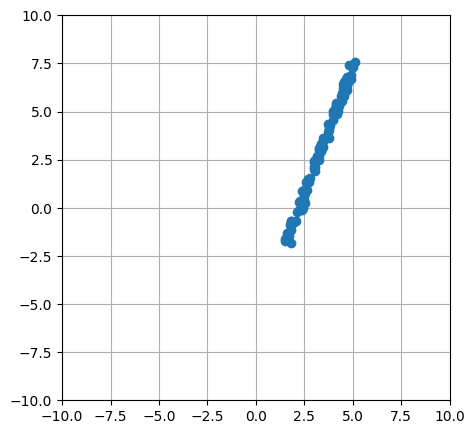

In [3]:
# plot size
plt.rcParams["figure.figsize"] = (5,5)

def show_points(points, a=None, b=None):
  # define area of interest
  plt.xlim(( -10, 10))
  plt.ylim((-10, 10))
  plt.grid()

  # plot points
  plt.plot(points[:,0], points[:,1], 'o')

  # plot line
  if a is not None and b is not None:
    X_ = np.linspace(-10.0, 10.0, num=2)
    plt.plot(X_, a*X_+b, 'r--')

  plt.show()

show_points(points)

## **Least squares fitting**

Obtain the slope and y-intercept values using the closed-form least squares solution.

Mean Squared Error: 0.06802849179901398


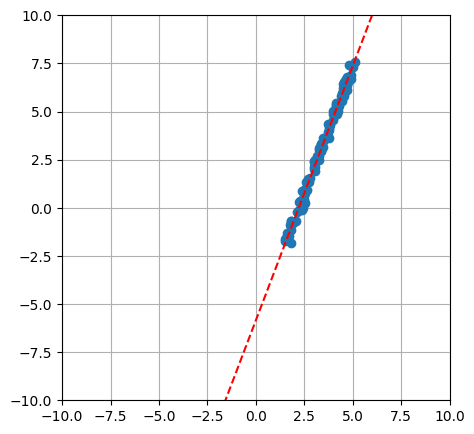

In [4]:
def loss(points, a, b):
    X = points[:,0]
    Y = points[:,1]
    return np.mean(np.square((a*X + b) - Y))

def least_squares(points):
    X = points[:,0]
    Y = points[:,1]

    X_mean = np.mean(X)
    Y_mean = np.mean(Y)

    a = np.sum(np.multiply(X-X_mean, Y-Y_mean)) / np.sum(np.square(X-X_mean))
    b = Y_mean - a * X_mean

    return a, b

a, b = least_squares(points)
print('Mean Squared Error:', loss(points, a, b))
show_points(points, a, b)

## **Gradient descent**

Obtain the slope and y-intercept values using multiple gradient descent updates.

Mean Squared Error before training: 16.791201862017306


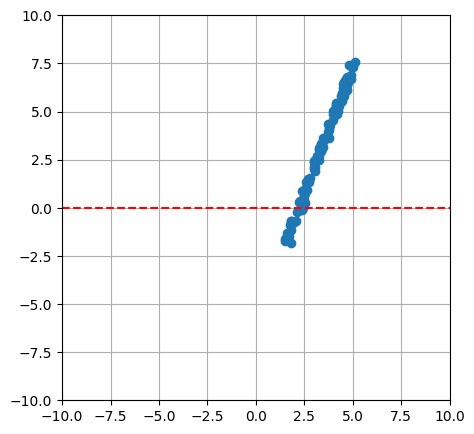


Mean Squared Error after 1 training iteration(s): 40.24172686900954


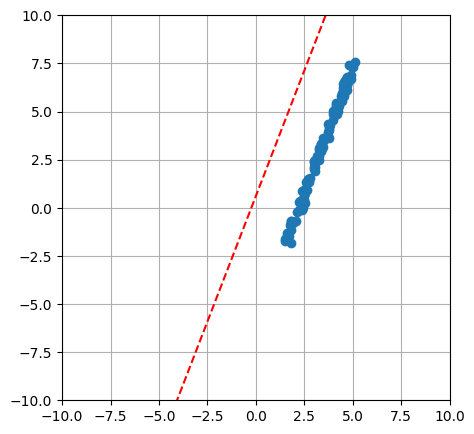


Mean Squared Error after 2 training iteration(s): 104.91355236446769


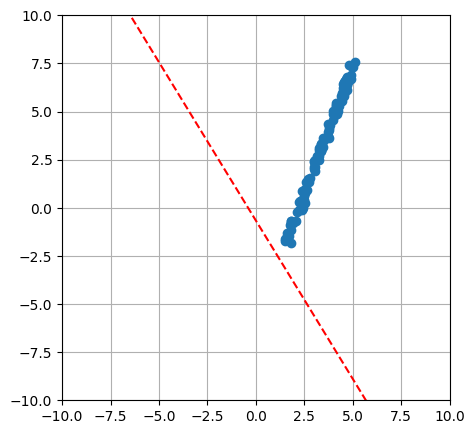


Mean Squared Error after 4 training iteration(s): 772.619770533369


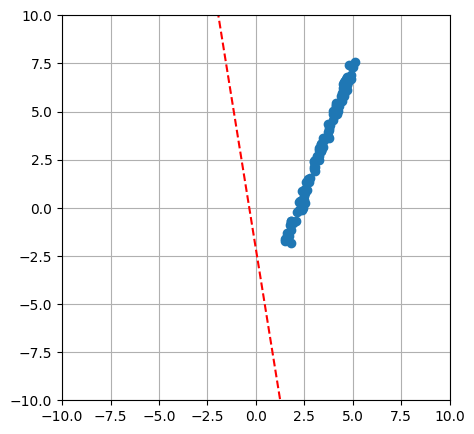


Mean Squared Error after 8 training iteration(s): 44010.618406086374


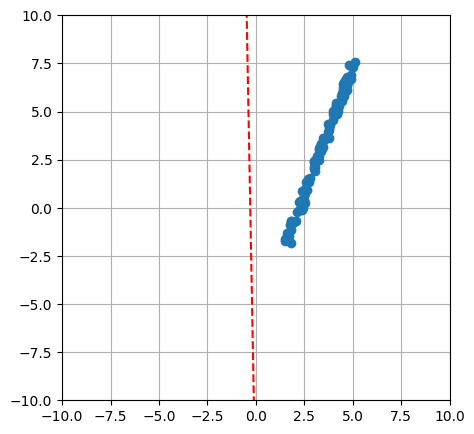


Mean Squared Error after 16 training iteration(s): 143867879.9965459


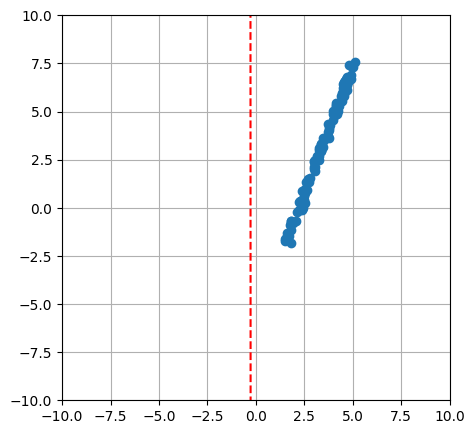


Mean Squared Error after 32 training iteration(s): 1537543656224265.2


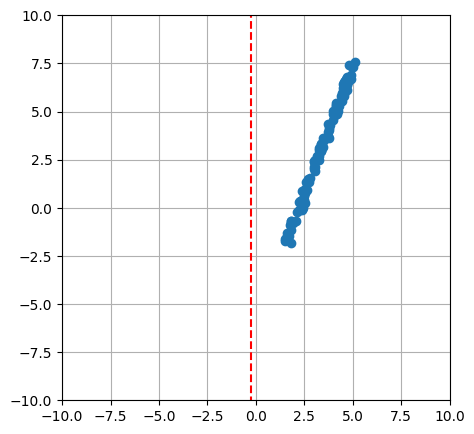


Mean Squared Error after 64 training iteration(s): 1.756122031394499e+29


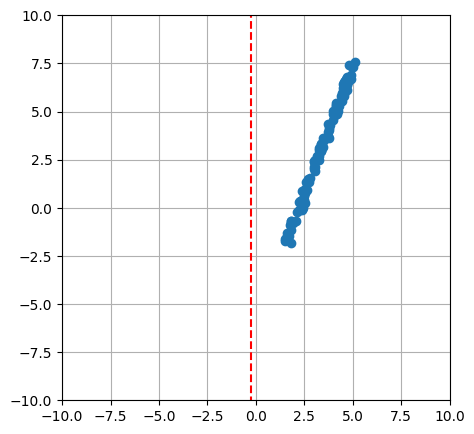


Mean Squared Error after 128 training iteration(s): 2.2909159851400202e+57


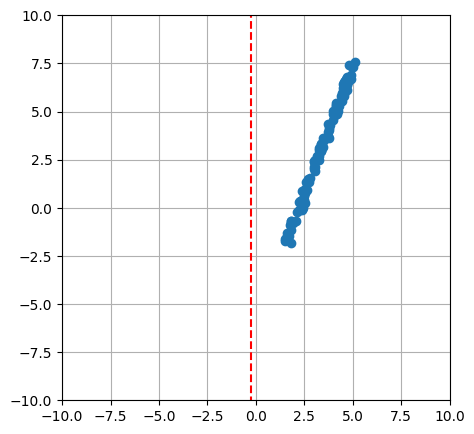


Mean Squared Error after 256 training iteration(s): 3.898684621807489e+113


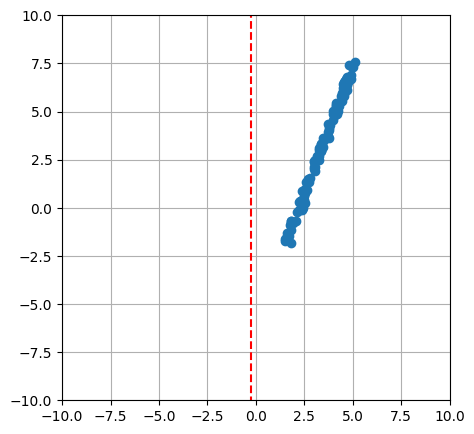


Mean Squared Error after 512 training iteration(s): 1.1291093139347206e+226


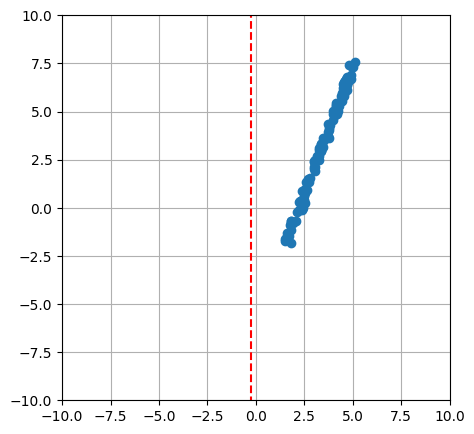


Mean Squared Error after 1024 training iteration(s): inf


/tmp/ipykernel_69344/2679162120.py:4: RuntimeWarning: overflow encountered in square
  return np.mean(np.square((a*X + b) - Y))


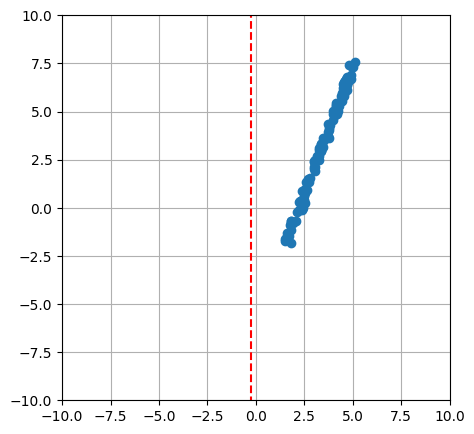

In [7]:
def gradient_descent_step(points, a, b, learning_rate):
    X = points[:,0]
    Y = points[:,1]

    tmp = ((a*X + b) - Y) * (2.0/len(points))
    a_grad = np.sum(np.multiply(tmp, X))
    b_grad = np.sum(tmp)

    a_ = a - learning_rate * a_grad
    b_ = b - learning_rate * b_grad

    return a_, b_

a, b = 0.0, 0.0
print('Mean Squared Error before training:', loss(points, a, b))
show_points(points, a, b)

log_count = 1
for i in range(1024): # plot results after 1,2,4,8,... iterations
    a, b = gradient_descent_step(points, a, b, 0.1)
    if i == log_count-1:
        print('\nMean Squared Error after {} training iteration(s):'.format(log_count), loss(points, a, b))
        show_points(points, a, b)
        log_count *= 2

---

# **Fitting a plane to a pointcloud**

## **Data generation**

![BMI](bmi.jpg)

Generate a surface with NxN points replicating the BMI table above. Height (H) varies from 1.4 to 2.1 meters and weight (W) varies from 40 to 130 kilograms. BMI values are computes as W/H^2. H, W and BMI are respectively mapped to x, y and z axes.

In [8]:
N = 20
min_height, max_height, min_weight, max_weight = 1.4, 2.1, 40, 130
min_bmi = int(min_weight/(max_height**2)+0.5)
max_bmi = int(max_weight/(min_height**2)+0.5)

# x and y coordinates
xtics = np.linspace(min_height, max_height, N)
ytics = np.linspace(min_weight, max_weight, N)

# 2D grid on x and y axes
x, y = np.meshgrid(xtics, ytics)

# use BMI as z coordinates
z = np.divide(y, np.square(x))

# input
X = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), axis=1)
print(X.shape)

# output
Y = z.reshape((-1,1))
print(Y.shape)

(400, 2)
(400, 1)


## **Visualize surface**

Plot the surface created in the previous step. The colors of the plot follow the pattern of the BMI table.

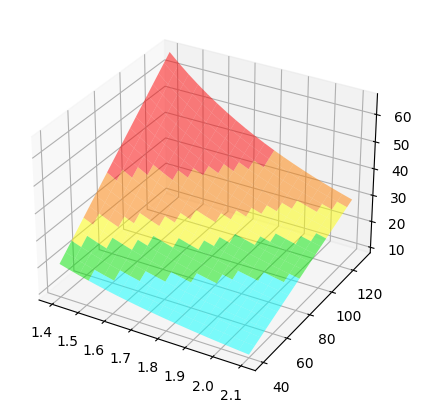

In [9]:
def show_surface(x, y, z, W=None, b=None):
    # 0-18: cyan / 19-24: green / 25-29: yellow / 30-39: orange / 40-*: red
    colors = [(0.0,1.0,1.0,0.5)]*(19-min_bmi) + [(0.0,0.9,0.0,0.5)]*6 + [(1.0,1.0,0.0,0.5)]*5 + [(1.0,0.5,0.0,0.5)]*10 + [(1.0,0.0,0.0,0.5)]*(max_bmi-39)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('BMI', colors, N=len(colors))

    # plot surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap=cmap)

    # plot line
    if W is not None and b is not None:
        z_ = W[0][0]*x+W[0][1]*y+b[0]
        ax.plot_wireframe(x, y, z_, color='black', lw=1)

    plt.show()

show_surface(x, y, z)

## **Initialize parameters**

Create a vector of weights (one weight per input dimension in each vector) and one bias for each output dimension.

Mean Squared Error: 987.6626799740377


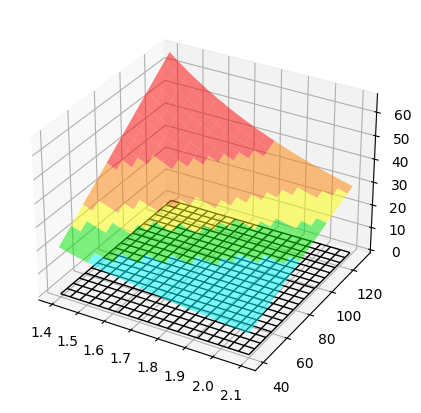

In [10]:
def loss(X, Y, W, b):
    return np.mean(np.square(np.matmul(X, np.transpose(W)) + b - Y))

W = np.zeros((1,2), dtype=np.float32)
b = np.zeros((1,), dtype=np.float32)

print('Mean Squared Error:', loss(X, Y, W, b))
show_surface(x, y, z, W, b)

## **Gradient descent**

Obtain the x-slope, y-slope and z-intercept values using multiple gradient descent updates.

Mean Squared Error before training: 987.6626799740377


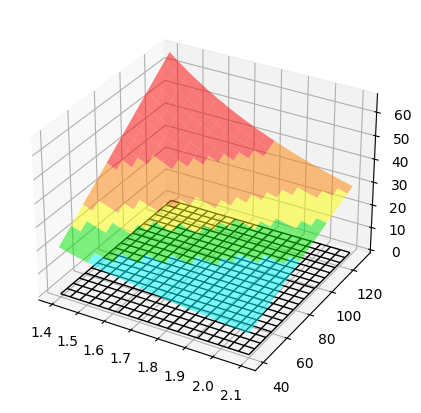


Mean Squared Error after 1 training iteration(s): 95.51874290171799


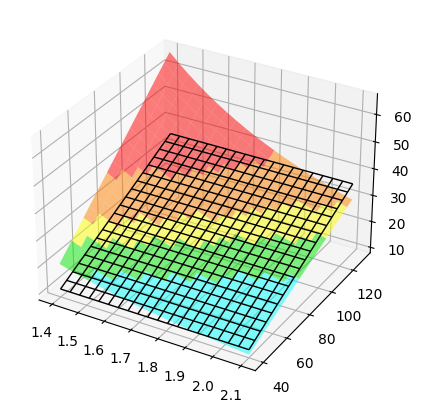


Mean Squared Error after 2 training iteration(s): 58.92525407205435


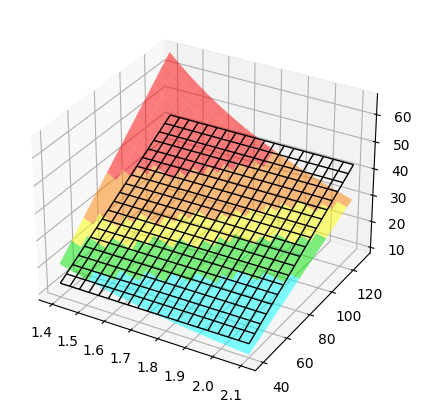


Mean Squared Error after 4 training iteration(s): 57.36183858808745


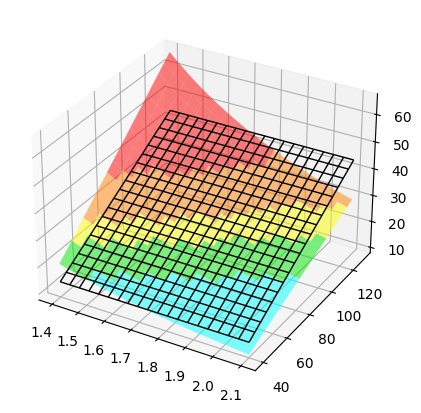


Mean Squared Error after 8 training iteration(s): 57.35737369626586


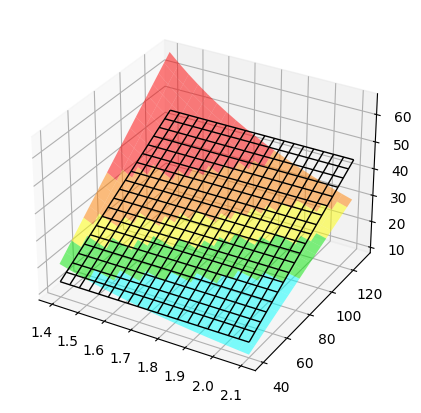


Mean Squared Error after 16 training iteration(s): 57.353711683813096


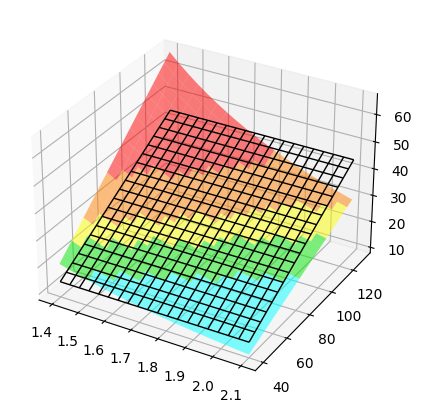


Mean Squared Error after 32 training iteration(s): 57.34639350338571


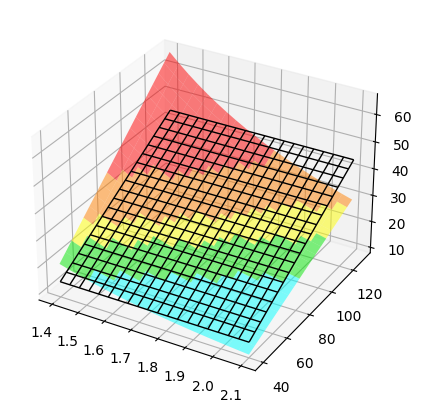


Mean Squared Error after 64 training iteration(s): 57.33178042494664


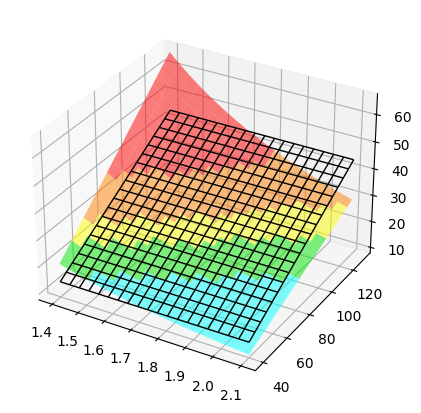


Mean Squared Error after 128 training iteration(s): 57.302647111465376


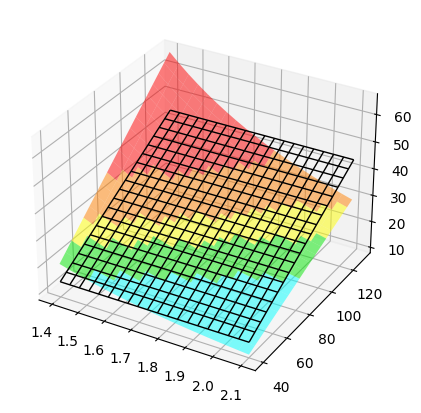


Mean Squared Error after 256 training iteration(s): 57.244749579328015


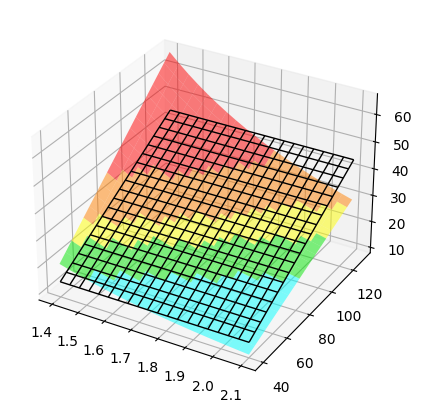

In [11]:
def gradient_descent_step(X, Y, W, b, learning_rate):
    tmp = (np.matmul(X, np.transpose(W)) + b - Y)
    W_grad = np.matmul(np.transpose(tmp), X) / X.shape[0]
    b_grad = np.mean(tmp, axis=0)

    W_ = W - learning_rate * W_grad
    b_ = b - learning_rate * b_grad

    return W_, b_

W = np.zeros((1,2), dtype=np.float32)
b = np.zeros((1,), dtype=np.float32)

print('Mean Squared Error before training:', loss(X, Y, W, b))
show_surface(x, y, z, W, b)

log_count = 1
for i in range(256):
    W, b = gradient_descent_step(X, Y, W, b, 0.0001)
    if i == log_count-1:
        print('\nMean Squared Error after {} training iteration(s):'.format(log_count), loss(X, Y, W, b))
        show_surface(x, y, z, W, b)
        log_count *= 2

## **Data normalization**

Normalize training data in a way that x, y, and z values are in the range from 0 to 1.

Mean Squared Error before training: 0.16804115268880682


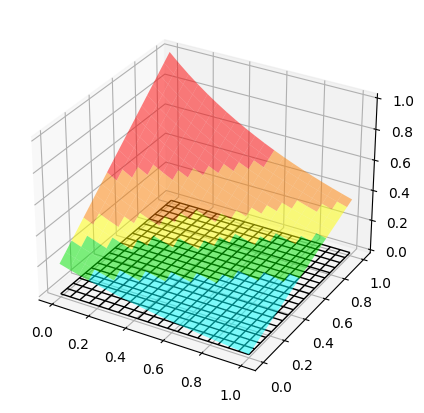


Mean Squared Error after 1 training iteration(s): 0.07193409589921775


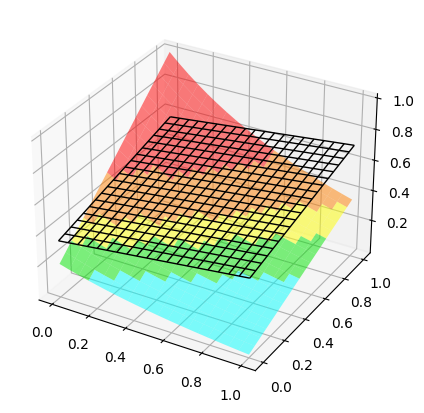


Mean Squared Error after 2 training iteration(s): 0.04073476259362855


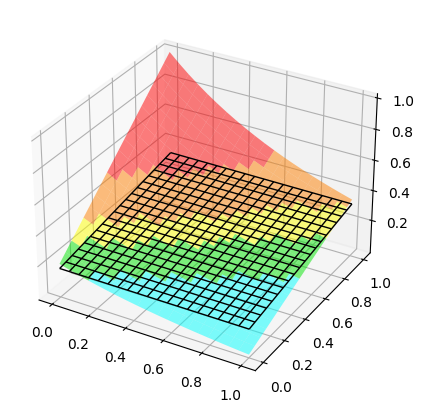


Mean Squared Error after 4 training iteration(s): 0.022450231317866578


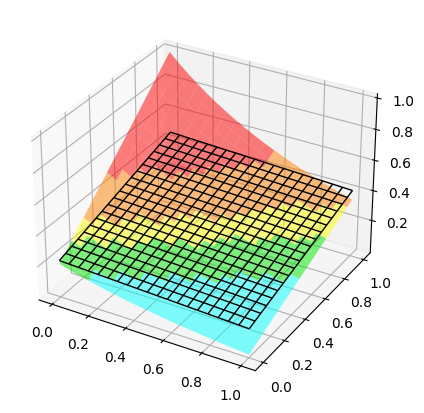


Mean Squared Error after 8 training iteration(s): 0.011175472727968688


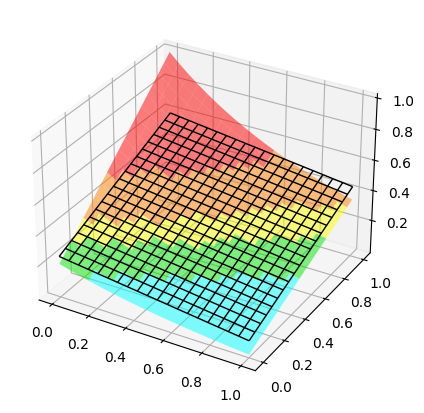


Mean Squared Error after 16 training iteration(s): 0.004051365140755161


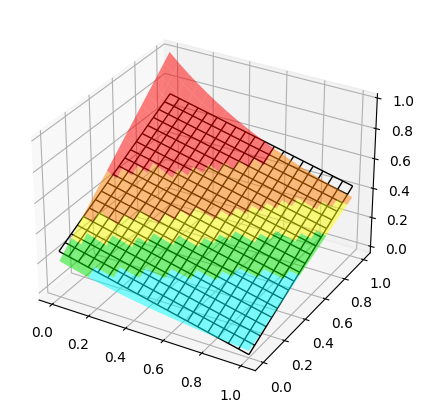


Mean Squared Error after 32 training iteration(s): 0.0021758260544047893


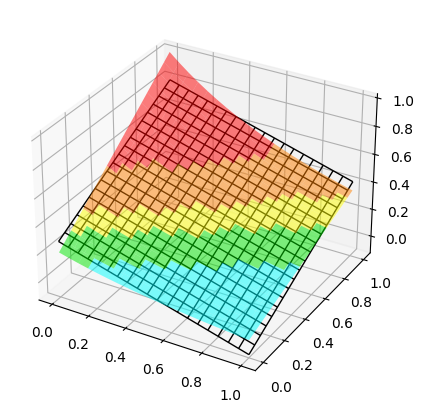


Mean Squared Error after 64 training iteration(s): 0.002078976295268292


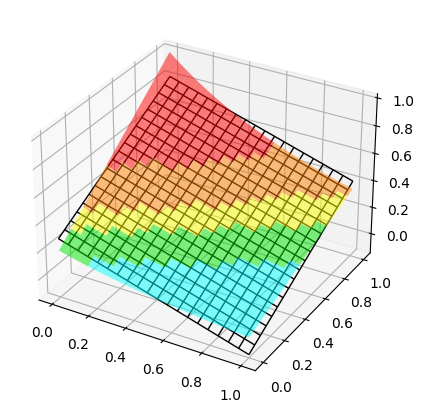


Mean Squared Error after 128 training iteration(s): 0.002078583170717962


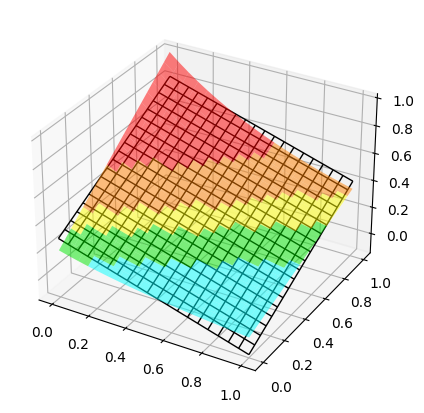


Mean Squared Error after 256 training iteration(s): 0.0020785830926620553


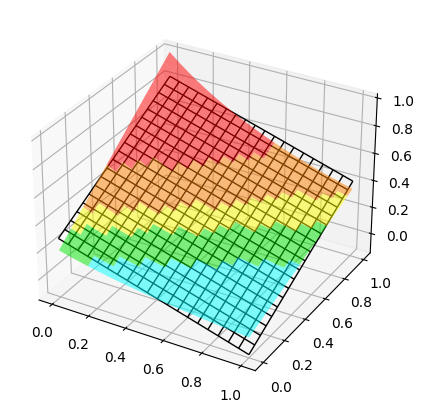

In [12]:
x_ = (x-min_height)/(max_height-min_height)
y_ = (y-min_weight)/(max_weight-min_weight)
z_ = (z-min_bmi)/(max_bmi-min_bmi)

X_ = np.concatenate((x_.reshape((-1,1)), y_.reshape((-1,1))), axis=1)
Y_ = z_.reshape((-1,1))

W = np.zeros((1,2), dtype=np.float32)
b = np.zeros((1,), dtype=np.float32)

print('Mean Squared Error before training:', loss(X_, Y_, W, b))
show_surface(x_, y_, z_, W, b)

log_count = 1
for i in range(256):
    W, b = gradient_descent_step(X_, Y_, W, b, 1.0)
    if i == log_count-1:
        print('\nMean Squared Error after {} training iteration(s):'.format(log_count), loss(X_, Y_, W, b))
        show_surface(x_, y_, z_, W, b)
        log_count *= 2